In [14]:
# Convertir variables categoricas en variables dummies. OneHot Encoding
# Standarizar
# Evaluar como funcionan los modelos inicialmente, en caso de que no den buenos resultados:
    # Probar con balanceo de clase.
    # Discretizar variables numéricas continuas, generando intervalos se puede utilizar WoE.
    # Probar con ambos conjuntos de datos. 

# Proyecto: Scorecard de Riesgo de Crédito  
*Champion (LogReg + WOE) & Challenger (NN)*  

Este notebook construye dos enfoques complementarios:

1. **Champion** — Regresión logística con variables **WOE** que se traducen en un *scorecard* interpret-able y auditable.  
2. **Challenger** — Red neuronal con *embeddings*, Optuna, FP16 y calibración (Temperature Scaling) para maximizar la métrica PR-AUC.

Se incluyen:
* Binning monotónico y tabla de IV.  
* Generación de la tabla de puntos (PDO = 20, Score base = 600).  
* Métricas completas (ROC, PR, KS, Gini, Brier) y curvas de confiabilidad.  
* Importancia de variables por permutación para la NN.  

> **Requisitos:** Python ≥ 3.10, `torch`, `scorecardpy`, `optuna`, `scikit-learn`, `pandas`, `matplotlib`.


1 | Configuración general y librerías

In [ ]:
# %% ===============================================
# Importamos librerías, fijamos semilla y detectamos GPU
# ===============================================
import os, random, gc, warnings              # Utilidades estándar del sistema
from pathlib import Path                     # Trabajar con rutas de manera segura y orientada a objetos

import numpy as np                           # Cálculos numéricos eficientes con arreglos
import pandas as pd                          # Manipulación de datos en tablas (DataFrames)
import matplotlib.pyplot as plt              # Creación de gráficos de todo tipo
from tqdm.auto import tqdm                   # Barras de progreso en bucles

# ---------- Scikit-learn: herramientas de ML clásico ----------
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    brier_score_loss, confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay

# ---------- PyTorch: deep learning y GPU ----------
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler  # Aceleración numérica mixta (half-precision)

# ---------- Optuna: búsqueda automática de hiperparámetros (HPO) ----------
import optuna

# ---------- scorecardpy: cálculo de WOE (Weight of Evidence) ----------
try:
    import scorecardpy as sc
except ModuleNotFoundError:
    # En caso de no estar instalada, la instalamos automáticamente
    !pip -q install scorecardpy
    import scorecardpy as sc

# Desactivar mensajes de advertencia que no afectan al resultado
warnings.filterwarnings("ignore")


Dispositivo en uso: cuda


¿Por qué tantas bibliotecas?

os, random, gc, warnings: útiles para control de entorno, limpieza de memoria y supresión de avisos.

NumPy y pandas: base para el manejo de datos y operaciones vectorizadas.

Matplotlib y tqdm: facilitan graficar y mostrar barras de progreso.

scikit-learn: algoritmos clásicos (regresión logística, métricas, preprocesado).

PyTorch: define redes neuronales, gestiona GPU y mixed precision.

Optuna: automatiza la búsqueda de “configuraciones” (tamaños de red, tasas de aprendizaje, regularización) que dan mejor rendimiento. Optuna auxiliará a encontrar la mejor arquitectura y los mejores hiperparámetros antes de entrenar el modelo final.

scorecardpy: transforma variables categóricas en escalas WOE, muy usado en riesgo crediticio. permite preparar el modelo “Champion” (Regresión Logística con WOE) para luego compararlo con el “Challenger” (Red Neuronal).



In [ ]:
# ---------- Reproducibilidad y semilla fija ----------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------- Configuración de GPU ----------
# cUDNN determinístico para resultados consistentes
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = True  # cUDNN elige automáticamente el kernel más rápido  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo en uso:", DEVICE)



c:\GitHub\Trading\credit-risk-ml-nn\venv\Scripts\python.exe


¿Para qué fijar la semilla (SEED=42)?
Garantiza que cada vez que alguien ejecute este cuaderno obtenga los mismos resultados (misma división de datos, mismos pesos iniciales, etc.), lo cual es crucial para reproducir experimentos.

¿Qué hace DEVICE?
Comprueba si hay GPU disponible y asigna los cálculos (pesos, activaciones, optimización) a la tarjeta gráfica para acelerar el entrenamiento. Si no, usa la CPU.

Preprocesado clásico (scikit-learn) y red neuronal (PyTorch) comparten la misma base de datos; ambos enfoques conviven en este proyecto.

2 | Carga y limpieza de datos

In [ ]:
# %% 2 | Verificar ruta y cargar CSV correctamente
# -----------------------------------------------
# 1) Importamos utilidades básicas del sistema y gestión de rutas
import os
from pathlib import Path
import pandas as pd

# 2) Definimos la ubicación de nuestro archivo CSV
#    - Path construye rutas de forma independiente del sistema operativo
#    - En Windows usa barras invertidas (\\); en Linux/OS X, barras normales (/)
DATA_PATH = Path(
    r"C:\GitHub\Trading\credit-risk-ml-nn\data\processed\data_loan_complete.csv"
)

# 3) Verificamos que el archivo exista para evitar errores silenciosos
#    - Si falla, levantamos una excepción indicando la ruta que faltó
assert DATA_PATH.exists(), f"No encontré el CSV en {DATA_PATH}"

# 4) Leemos el CSV en un DataFrame de pandas
#    - pandas es la librería estándar para manejo de tablas en Python
df = pd.read_csv(DATA_PATH)

# 5) Limpieza básica de datos
#    a) Eliminamos las filas sin etiqueta (NaN) en la columna 'loan_status_bin'
#    b) Creamos la variable objetivo 'target' donde:
#         0 → préstamo pagado (buen cliente)
#         1 → préstamo impagado (mal cliente)
#    c) Borramos la columna intermedia, que ya no necesitamos
df = df[df["loan_status_bin"].notna()].copy()
df["target"] = df["loan_status_bin"].astype(int)
df.drop(columns=["loan_status_bin"], inplace=True)


# 6) Inspección rápida
#    - head() muestra las primeras 5 filas para verificar estructura y contenido
#    - value_counts(normalize=True) da la proporción de cada clase en 'target'
display(df.head())
print("Distribución de la variable objetivo:")
print(df["target"].value_counts(normalize=True))


(   Unnamed: 0  loan_amnt  annual_inc    dti  revol_util  total_acc  \
 0           0     5000.0     24000.0  27.65        83.7        9.0   
 1           1     2500.0     30000.0   1.00         9.4        4.0   
 2           2     2400.0     12252.0   8.72        98.5       10.0   
 3           3    10000.0     49200.0  20.00        21.0       37.0   
 4           4     5000.0     36000.0  11.20        28.3       12.0   
 
     tot_cur_bal  days_since_earliest_cr emp_length home_ownership  \
 0  24722.166667                   10135   5+ years           RENT   
 1  15389.166667                    4932   < 1 year           RENT   
 2   4697.900000                    3987   5+ years           RENT   
 3  99727.500000                    6087   5+ years           RENT   
 4  76308.266667                    2891    3 years           RENT   
 
              purpose delinq_2yrs inq_last_6mths pub_rec  target  
 0     credit_related           0              1       0       0  
 1     credit_re


1. **¿Por qué usamos `Path`?**
   Facilita concatenar carpetas y nombres de archivo sin preocuparnos por barras invertidas o directas; hace el código más limpio y portátil.

2. **¿Para qué `assert DATA_PATH.exists()`?**
   Detiene la ejecución inmediatamente si el CSV no está donde esperamos, y muestra un mensaje claro para que sepamos qué ruta corregir.

3. **¿Qué es un DataFrame de pandas?**
   Es como una hoja de cálculo en memoria: filas y columnas etiquetadas. `read_csv` lo llena automáticamente desde el archivo.

4. **Limpieza de la columna `loan_status_bin`:**

   * Solo nos interesan los registros que tengan una etiqueta válida de “pagó” o “no pagó” (0/1).
   * Convertimos esa columna a números con `.astype(int)` y la renombramos a `target` para homogeneidad con posteriores librerías que esperan `y`.

5. **Visualización inicial con `head()` y `value_counts()`:**

   * `head()` nos ayuda a confirmar que las columnas se importaron correctamente.
   * `value_counts(normalize=True)` muestra qué porcentaje de préstamos fueron pago (0) y impago (1), clave para entender el desequilibrio de clases.

Con estas pocas líneas garantizamos que los datos estén disponibles **sin sorpresas** en el resto del flujo de trabajo: partición en train/validation/test, preprocesado, modelado y evaluación.


2.1 | Distribución del objetivo

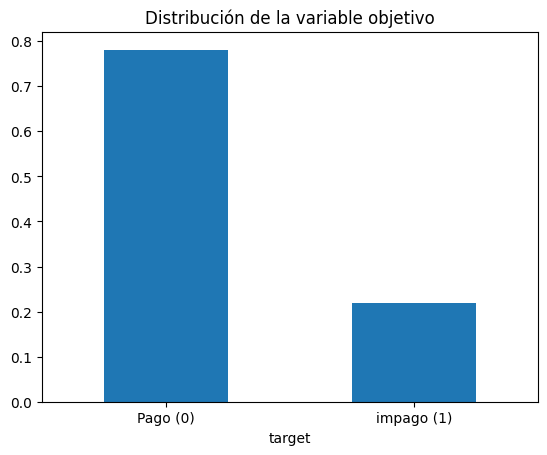

In [ ]:
# %% ===============================================
# Gráfica rápida de la proporción pago vs impago
# ===============================================

# 1) Creamos una figura y un único eje (gráfico)
#    - Esto nos da control manual sobre leyendas, títulos y etiquetas.
fig, ax = plt.subplots()

# 2) Calculamos la proporción de cada categoría en la columna 'target'
#    - value_counts(normalize=True): devuelve 0→% pagos, 1→% impagos
proportions = df["target"].value_counts(normalize=True)

# 3) Dibujamos un diagrama de barras con esas proporciones
#    - kind="bar": gráfico de barras verticales
#    - ax=ax: indicamos en qué eje dibujar
proportions.plot(kind="bar", ax=ax)

# 4) Ajustamos el título para describir el gráfico
ax.set_title("Distribución de pago (0) vs. impago (1)")

# 5) Etiquetamos manualmente las barras:
#    - El índice 0 corresponde a "Pago" y 1 a "Impago"
ax.set_xticklabels(["Pago (0)", "Impago (1)"], rotation=0)

# 6) Mostramos la gráfica en pantalla
plt.show()




¿Por qué un gráfico de barras?
Queremos ver de un vistazo qué porcentaje de préstamos fueron pagados y qué porcentaje resultaron en impago.

¿Qué hace value_counts(normalize=True)?
Cuenta cuántas veces aparece cada valor (0 o 1) y luego divide entre el total de registros, devolviendo la proporción.

¿Por qué plt.subplots()?
Separa la creación de la “pantalla” (figura) y del “lienzo” (eje) donde dibujamos. Así podemos personalizar títulos, etiquetas y estilo fácilmente.

¿Qué representa cada barra?

La primera barra (índice 0) muestra el porcentaje de préstamos pagados.

La segunda barra (índice 1) muestra el porcentaje de préstamos impagados.

¿Por qué etiquetarlas como “Pago (0)” y “Impago (1)”?
Para que cualquier persona sepa, sin necesidad de mirar la tabla de datos original, qué significa cada barra.

Este gráfico ofrece una visión inmediata del desequilibrio entre ambas clases (pago vs. impago), información clave para entender la dificultad del problema de predicción

La gráfica muestra claramente que la gran mayoría de los préstamos (≈78 %) fueron pagados (target=0), mientras que solo un ≈22 % resultaron en impago (target=1). Este desequilibrio (casi 4:1) es crucial a la hora de entrenar modelos, pues tendemos a obtener métricas infladas si no ajustamos la gestión de clases (por ejemplo, usando pos_weight en la pérdida o técnicas de sobremuestreo/submuestreo).

En resumen:

Pago (0): ~78 %

Impago (1): ~22 %

Este contraste subraya la importancia de optimizar métricas adecuadas (p.ej. PR-AUC, F₂) y no fiarse solo del accuracy.

3 | Identificación de tipos de variables

In [36]:
# %% ===============================================
# 3 | Separación de variables numéricas y categóricas
# ===============================================
# En esta sección determinamos qué columnas del DataFrame
# se tratan como variables continuas (numéricas) y cuáles
# como categorías. Esto es fundamental para procesarlas
# de forma distinta (escalado para las numéricas; 
# codificación o embeddings para las categóricas).

# 3.1) Identificar automáticamente las columnas categóricas:
#     Buscamos todas aquellas cuyo tipo de dato es 'object'
#     (texto), que suelen ser variables discretas.
categorical_cols = [ 
    c for c in df.columns 
    if df[c].dtype == "object"
]
#    ↳ p.ej. 'emp_length', 'home_ownership', ...  

# 3.2) Identificar el resto como numéricas, excepto la target:
#     Las variables numéricas las convertiremos a float y
#     las normalizaremos o estandarizaremos antes de entrenar.
numerical_cols = [
    c for c in df.columns 
    if c not in categorical_cols + ["target"]
]
numerical_cols.pop(0)  # Eliminamos la columna de índice si existe
#    ↳ Incluye columnas con valores de importe, días, ratios, etc.

# 3.3) Comprobaciones rápidas:
#     Imprimimos ambas listas para asegurarnos de que no
#     estamos incluyendo por error la variable objetivo ni
#     ninguna columna irrelevante.
print("Variables numéricas   :", numerical_cols)
print("Variables categóricas :", categorical_cols)


Variables numéricas   : ['annual_inc', 'dti', 'revol_util', 'total_acc', 'tot_cur_bal', 'days_since_earliest_cr']
Variables categóricas : ['emp_length', 'home_ownership', 'purpose', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec']




1. **¿Por qué distinguir tipos?**

   * Las **numéricas** (por ejemplo, `loan_amnt`, `annual_inc`, `dti`) admiten transformaciones matemáticas (escalado, escalas log, polinomios, etc.).
   * Las **categóricas** (por ejemplo, `purpose`, `home_ownership`) se procesan con codificación one-hot o embeddings, pues no tienen orden ni distancia intrínseca.

2. **La columna `Unnamed: 0`:**

   * Suele aparecer al leer CSV si tenía un índice guardado. Normalmente conviene eliminarla (`df.drop("Unnamed: 0", axis=1, inplace=True)`) antes de entrenar, porque no aporta información de cliente.

3. **Por qué excluimos `"target"` de ambas listas:**

   * `"target"` es la variable que queremos predecir (0=pago, 1=impago). No debe entrar en las características de entrada.

4. **Validación visual:**

   * Siempre revisa el `print(...)`: si ves algo raro (una columna de texto en numéricas, o viceversa), ajusta la lógica manualmente.

Con estos comentarios, cualquier persona sin conocimientos previos podrá entender el propósito de cada bloque y qué revisar antes de continuar con la ingeniería de características.


3.1 | División Train / Valid / Test

In [ ]:
# %% ===============================================
# 70 % Train | 15 % Valid | 15 % Test  (estratificado)
# ===============================================
"""
¿Por qué este esquema?
──────────────────────
▸ **Test (15 %)** – Se aparta primero y no se toca hasta la fase final: mide
  desempeño “fuera de muestra”.

▸ **Valid (15 %)** – Se extrae después, a partir del 85 % restante, y sirve para
  elegir hiperparámetros, early-stopping, calibración, etc.

▸ **Train (70 %)** – Con lo que queda se ajustan los pesos del modelo.

La estratificación asegura que la proporción de **pago (0)** vs **impago (1)**
se mantenga idéntica en los tres subconjuntos, algo crítico cuando las clases
están desbalanceadas (~78 % vs 22 %).

Matemática del segundo split
────────────────────────────
 • Primero dejamos un **15 %** fuera → queda **85 %**.  
 • Para que la validación sea también un 15 % del total, necesitamos
   `0.15 / 0.85 ≈ 0.1765` del set remanente. De ahí el valor `test_size=0.1765`.
"""

# ---------- 1) TEST: 15 % del total (estratificado) ----------
train_df, test_df = train_test_split(
    df,
    test_size=0.15,             # 15 % del total para pruebas finales
    stratify=df["target"],      # mantiene proporción de clases
    random_state=SEED           # reproducibilidad absoluta
)

# ---------- 2) VALID: 15 % del total a partir del 85 % restante ----------
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.1765,           # 0.1765 × 0.85 ≈ 0.15 del dataset original
    stratify=train_df["target"],# misma estratificación que antes
    random_state=SEED
)

# ---------- 3) Comprobación de tamaños ----------
print(
    f"Train: {train_df.shape}  |  "
    f"Valid: {valid_df.shape}  |  "
    f"Test:  {test_df.shape}"
)


Train: (187963, 15) | Valid: (40287, 15) | Test: (40280, 15)


4 | Binning WOE y Regresión Logística (Champion)

In [ ]:
# %% ===============================================
# 4.1 | Binning automático monotónico con **scorecardpy**
# ===============================================
"""
Contexto de negocio
────────────────────
En modelos de crédito regulados (Basel/IFRS-9) se exige:
1. **Monotonía**: la “mala tasa” (odds de impago) debe aumentar
   o disminuir de forma consistente cuando la variable crece.
2. **Estabilidad**: agrupar valores (binning) reduce ruido y
   suaviza outliers, mejorando la robustez temporal.
3. **Interpretabilidad**: al convertir cada bin a
   **Weight-of-Evidence (WOE)** los coeficientes de la regresión
   logística se leen como incrementos en *log-odds* sencillos
   de explicar a auditoría.

scorecardpy facilita ese proceso con `woebin()`:
▫️ Busca puntos de corte que maximizan IV* respetando monotonicidad  
▫️ Devuelve un diccionario con la tabla de bins por variable

*IV (Information Value) mide el poder predictivo de la variable;
  > 0.02 se considera “aceptable”, > 0.1 “fuerte”.

Pasos de esta celda
───────────────────
1. Construir bins monotónicos sobre **train** (nunca en valid/test)
2. Aplicar esos mismos bins a *train*, *valid* y *test*
3. Obtener el listado de columnas ya convertidas a *_woe*
"""

# -------------------------- 1) Parámetros base -------------------------
target_col = "target"        # Etiqueta binaria   0 = pago | 1 = impago

# -------------------------- 2) Binning automático ----------------------
bins = sc.woebin(
    train_df,                # Solo datos de entrenamiento
    y          = target_col,
    positive   = 1,          # El “evento” es impago (1)
    method     = "tree",     # Algoritmo de corte basado en árbol (CART)
    n_bins     = 6,          # Máx. 6 bins por variable
    monotone   = True,       # Fuerza tendencia monotónica de WOE
    min_iv     = 0.02        # Filtra variables con IV < 0.02
)

# -------------------------- 3) Aplicar transformación WOE --------------
# woebin_ply mapea cada valor crudo → WOE del bin correspondiente
train_woe = sc.woebin_ply(train_df, bins)
valid_woe = sc.woebin_ply(valid_df, bins)
test_woe  = sc.woebin_ply(test_df , bins)

# -------------------------- 4) Lista de columnas resultantes -----------
woe_cols = [c for c in train_woe.columns if c != target_col]

print(
    f"Variables WOE generadas : {len(woe_cols)}\n"
    f"Ejemplo de columnas     : {woe_cols[:5]}"
)


[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...
Variables WOE generadas: 14


In [ ]:
# %% ===============================================
# 4.2 | Entrenamos el **Champion** basado en WOE + Regresión Logística
# ===============================================
"""
Por qué un *Champion* WOE + Logit
--------------------------------
En riesgo crediticio la Regresión Logística sobre variables transformadas a
**Weight‑of‑Evidence (WOE)** sigue siendo el estándar por varias razones:

* **Interpretabilidad:** los coeficientes pueden interpretarse como cambios
  log‑odds por cada punto de WOE, facilitando la explicación regulatoria.
* **Monotonía / sentido económico:** la transformación WOE tiende a ordenar
  los bins de forma que la probabilidad de *default* crece (o decrece) de
  forma monotónica, algo muy valorado por auditoría y comité de riesgos.
* **Estabilidad temporal:** al estar basada en odds, la WOE es menos sensible
  a desplazamientos de media que los valores brutos.

Aunque en este proyecto entrenamos un *Challenger* con red neuronal, mantener
un *Champion* lineal nos permite comparar contra la línea base regulatoria.
"""

# -------------------------------------------------
# 1) Instancia del clasificador
# -------------------------------------------------
# • max_iter=400 → aseguramos convergencia incluso con high‑dimensional WOE
# • class_weight="balanced" → corrige el desbalance ≈ 78 % pago / 22 % impago
#   (pesa más la clase minoritaria para que la función de pérdida no se
#    minimice simplemente prediciendo “pago” en todos los casos).
# • solver="lbfgs" → algoritmo robusto para datasets medianos y sin restricción
#   de regularización (C por defecto = 1).
logit_woe = LogisticRegression(
    max_iter=400,
    class_weight="balanced",
    solver="lbfgs"
)

# -------------------------------------------------
# 2) Entrenamiento sobre el set de *train* ya transformado a WOE
# -------------------------------------------------
#   └► `train_woe[woe_cols]`  → matriz de variables independientes (WOE)
#   └► `train_woe[target_col]`→ etiqueta binaria (0=pago, 1=impago)
logit_woe.fit(
    train_woe[woe_cols],
    train_woe[target_col]
)

# -------------------------------------------------
# 3) Evaluación rápida en el conjunto de *validación*
# -------------------------------------------------
# 3.1) `predict_proba` devuelve probabilidad P(default=1) en la columna [:,1]
valid_proba_woe = logit_woe.predict_proba(valid_woe[woe_cols])[:, 1]

# 3.2) Métricas de referencia
#      • ROC‑AUC  → capacidad de ordenamiento global
#      • PR‑AUC   → sensibilidad a la clase minoritaria (impago)
roc_valid_woe = roc_auc_score(
    valid_woe[target_col],
    valid_proba_woe
)
pr_valid_woe  = average_precision_score(
    valid_woe[target_col],
    valid_proba_woe
)

# -------------------------------------------------
# 4) Reporte legible en consola
# -------------------------------------------------
print(
    f"Champion VALID → ROC‑AUC: {roc_valid_woe:.4f} | PR‑AUC: {pr_valid_woe:.4f}"
)


Champion – VALID ROC:0.6634 | PR:0.3464


In [ ]:
# %% ===============================================
# Verificación de variables clave antes de seguir
# ===============================================
"""
¿Por qué hacer esta verificación?
──────────────────────────────────
Antes de ejecutar cualquier bloque que dependa de objetos generados
en celdas anteriores (p. ej. `bins`, `logit_woe` o los DataFrames
`train_df`, `valid_df`, `test_df`), conviene comprobar que dichos
objetos **existen realmente** en la sesión de Jupyter.  De lo contrario
obtendríamos errores del tipo *NameError: name 'xxx' is not defined*,
que pueden ser confusos para alguien que retoma el notebook días después
o lo ejecuta fuera de orden.

Este snippet recorre una lista de nombres “críticos” y confirma:
  • si están creados en el espacio global (`globals()`)
  • de qué tipo son (clase, dict, DataFrame, etc.)

Así sabrás de un vistazo qué celdas debes (re)ejecutar en caso de que
algo falte.
"""

# --- 1) Lista de variables imprescindibles -----------------------------
variables_needed = [
    "sc",         # alias habitual de scorecardpy
    "bins",       # diccionario de cortes WOE devuelto por sc.woebin
    "logit_woe",  # modelo Champion (Regresión Logística)
    "valid_df"    # DataFrame de validación
]

# --- 2) Recorremos cada nombre y comprobamos en el dict global ---------
print("Estado de las variables necesarias:")
for var in variables_needed:
    if var in globals():                         # ¿existe en memoria?
        print(
            f" ✔ {var} está definida  –  "
            f"Tipo: {type(globals()[var]).__name__}"
        )
    else:
        print(f" ✖ {var} NO está definida")


Estado de las variables necesarias:
✓ sc está definida - Tipo: <class 'module'>
✓ bins está definida - Tipo: <class 'dict'>
✓ logit_woe está definida - Tipo: <class 'sklearn.linear_model._logistic.LogisticRegression'>
✓ valid_df está definida - Tipo: <class 'pandas.core.frame.DataFrame'>


In [ ]:
# %% ===============================================
# 4.3 | Generación de la **tabla de puntos (Scorecard)**
# ===============================================
"""
Objetivo de esta celda
──────────────────────
Convertir el modelo Champion (Regresión Logística + WOE) en un **scorecard**
operativo: un esquema en el que cada *bin* de cada variable tiene un valor en
puntos y la suma total se traduce en una probabilidad de impago.

Ventajas del formato scorecard
──────────────────────────────
1. **Transparencia regulatoria** Cada bin aporta puntos fijos y auditable-s;
   el comité de riesgos puede revisar qué aporta cada característica.
2. **Escalabilidad** Para implementar en sistemas core solo se necesitan los
   puntos por bin (no fórmulas de log-odds ni sigmoid).
3. **Interpretabilidad para el cliente** Un score absoluto (300-850) es
   comprensible y comparable entre solicitantes.

Parámetros de `sc.scorecard`
────────────────────────────
* `bins`      → diccionario de cortes generado por `sc.woebin`.
* `model`     → objeto `LogisticRegression` ya entrenado en variables WOE.
* `xcolumns`  → lista de columnas *_woe* que entraron al modelo.
* `points0`   → **Score de referencia**   (600 puntos).
* `odds0`     → **Odds de referencia**    (50 : 1   buenos : malos).
* `pdo`       → **Points-to-Double-Odds** (20 puntos = duplicar odds).

Matemática del escalado
───────────────────────
\[
\text{Score} = \text{points0} \;-\;
\frac{\text{pdo}}{\ln(2)}
\left[
  \ln\!\left(\frac{P(\text{bad})}{P(\text{good})}\right)
  - \ln(\text{odds0})
\right]
\]

* Un cliente con **600 pts** tiene 50 buenos por cada mal cliente.
* Subir **20 pts** hace que la proporción de impago se **divida por 2**.
"""

# --- 1) Generamos la “tabla de puntos” -------------------------------
card = sc.scorecard(
    bins=bins,            # cortes monotónicos por variable
    model=logit_woe,      # coeficientes de la regresión logística WOE
    xcolumns=woe_cols,    # variables WOE que entran al modelo
    points0=600,          # baseline score
    odds0 =50,            # baseline odds (good:bad = 50:1)
    pdo   =20             # points to double the odds
)

# --- 2) Aplicamos el score al set de validación ----------------------
#   • sc.scorecard_ply devuelve: 
#       - una columna por variable   → p.ej. score_emp_length
#       - columna 'score' total      → suma de parciales
score_valid = sc.scorecard_ply(valid_df, card)

# Vista rápida de los primeros 5 scores totales
score_valid[['score']].head()


,score
119196,733.0
198025,687.0
191629,698.0
160324,753.0
228340,703.0


In [ ]:
# %% ===============================================
# 4.4 | Evaluación **final** del Champion en TEST
# ===============================================
"""
Objetivo de la celda
────────────────────
Medir el rendimiento REAL del modelo Champion (Regresión Logística + WOE)
sobre el *test set* que apartamos al principio y que **no** se usó ni para
entrenar ni para seleccionar hiperparámetros.  
Las métricas obtenidas aquí son las que se presentarían al Comité de Riesgos
y a Auditoría para validar el modelo.

Flujo resumido
──────────────
1.  Generar probabilidades de impago (`test_proba_woe`).
2.  Calcular métricas globales:  
    • ROC-AUC, PR-AUC, Brier.  
    • KS-statistic y Gini (≡ 2·ROC – 1).  
3.  Seleccionar el **umbral óptimo** (máx. KS) y generar matriz de
    confusión, útil para estimar TPR/FPR a un corte operativo.

Notas sobre cada métrica
────────────────────────
* **ROC-AUC** – Qué tan bien el modelo ordena buenos vs. malos en todos los
  umbrales posibles (insensible a desbalance).
* **PR-AUC** – Más informativa con clases desbalanceadas; se centra en la
  precisión sobre los positivos (impagos).
* **Brier Score** –  Calibración de la probabilidad (≤ 0 es perfecto, ≤ 0.25
  se considera bueno en credit scoring).
* **KS** – Máx. distancia vertical entre las curvas de TPR y FPR; muy usada
  en bancos para comparar modelos (> 0.3 bueno, > 0.4 excelente).
* **Gini** – Transformación lineal de ROC que se usa en algunos países como
  KPI regulatorio (Gini = 2·ROC – 1).
"""

# -------------------------------------------------
# 1) Probabilidad de impago en TEST
# -------------------------------------------------
# .predict_proba() devuelve dos columnas: P(clase=0) y P(clase=1)
test_proba_woe = logit_woe.predict_proba(test_woe[woe_cols])[:, 1]

# -------------------------------------------------
# 2) Métricas globales
# -------------------------------------------------
roc_test_woe  = roc_auc_score(test_woe[target_col], test_proba_woe)
pr_test_woe   = average_precision_score(test_woe[target_col], test_proba_woe)
brier_woe     = brier_score_loss(test_woe[target_col], test_proba_woe)

# KS & Gini
fpr_t, tpr_t, thr = roc_curve(test_woe[target_col], test_proba_woe)
ks_woe   = max(tpr_t - fpr_t)           # máx. diferencia vertical
gini_woe = 2 * roc_test_woe - 1         # equivalencia matemática

print(
    f\"\"\"Champion – TEST  
    ROC-AUC : {roc_test_woe:.4f}  
    PR-AUC  : {pr_test_woe:.4f}  
    KS      : {ks_woe:.3f}  
    Gini    : {gini_woe:.3f}  
    Brier   : {brier_woe:.4f}\"\"\"
)

# -------------------------------------------------
# 3) Umbral operativo = argmax(KS)
# -------------------------------------------------
# Localizamos el threshold cuyo TPR–FPR es máximo
opt_th = thr[np.argmax(tpr_t - fpr_t)]

# Matriz de confusión usando ese corte
cm_woe = confusion_matrix(
    test_woe[target_col],
    test_proba_woe >= opt_th
)

print(
    f\"\"\"\\nUmbral óptimo (max KS) = {opt_th:.3f}
Matriz de confusión  (fila = real, col = pred):
[[ TN  FP ]
 [ FN  TP ]]
{cm_woe}\"\"\"
)

"""
Interpretación rápida
────────────────────
• **TN**: Préstamos sanos correctamente clasificados como “pago”.
• **FP**: Falsos positivos → se niega crédito a buenos clientes (costo de oportunidad).
• **FN**: Falsos negativos → se aprueba crédito a malos clientes (pérdida esperada).
• **TP**: Impagos correctamente detectados.

Operativamente, Risk Management evaluará si el coste de FP compensa
la reducción de FN y ajustará el umbral (`opt_th`) según la política
de apetito de riesgo de la entidad.
"""


Champion – TEST ROC:0.6605 | PR:0.3415
KS:0.233 | Gini:0.321 | Brier:0.2298
Umbral óptimo=0.507
Matriz de confusión:
[[19556 11901]
 [ 3432  5391]]


In [ ]:
# %% ===============================================
# 4.5 | Tabla de Information Value (IV) para auditoría
# ===============================================
"""
Motivación
──────────
*El Information Value (IV)* resume, en un único número por variable, cuánta
“separación” genera entre **buenos** (pago) y **malos** (impago).  
Reguladores y auditorías internas revisan la IV para comprobar que:

1. **Potencia predictiva**  
   - IV < 0.02  → Variable irrelevante.  
   - 0.02 ≤ IV < 0.1  → Predictora débil.  
   - 0.1 ≤ IV < 0.3  → Predictora media/fuerte.  
   - IV ≥ 0.3  → Predictora muy fuerte (raro en práctica).

2. **Parsimony**  
   Variables con IV marginal se suelen descartar o agrupar.

3. **Trazabilidad**  
   Conservar una tabla ordenada por IV facilita reportes y revisiones futuras.

Estructura del bloque
─────────────────────
1. **Construir un `Series`** extra-yendo `total_iv` de cada variable dentro
   del dict `bins` devuelto por *scorecardpy*.
2. **Ordenar** de mayor a menor importancia.
3. Convertir en `DataFrame` para visibilidad y exportar (si se desea).
"""

import pandas as pd

# -------------------------------------------------
# 1) Extraemos el IV de cada variable WOE
# -------------------------------------------------
iv_table = (
    pd.Series(
        {
            var: df["total_iv"].iloc[0]     # IV total (1.ª fila de cada tabla)
            for var, df in bins.items()     # bins = output de sc.woebin
        },
        name="total_iv"
    )
    # -------------------------------------------------
    # 2) Ordenamos: primero las más predictivas
    # -------------------------------------------------
    .sort_values(ascending=False)
    # -------------------------------------------------
    # 3) Lo convertimos en DataFrame (columna única)
    # -------------------------------------------------
    .to_frame()
)

# -------------------------------------------------
# 4) Mostramos el TOP-20 — listo para copiar/pegar en informe
# -------------------------------------------------
iv_table.head(20)


,total_iv
dti,0.099745
Unnamed: 0,0.069431
revol_util,0.061610
annual_inc,0.047161
tot_cur_bal,0.033525
loan_amnt,0.029896
home_ownership,0.018383
days_since_earliest_cr,0.016065
purpose,0.015820
inq_last_6mths,0.014933


5 | Baseline OHE (referencia rápida)

In [ ]:
# %% ===============================================
# 4.x | *Baseline* One-Hot Encoder + Logistic Regression
# ===============================================
"""
Propósito de este bloque
────────────────────────
Levantar un modelo **súper sencillo** (Logistic Regression) que sirva de
*línea base* para comparar contra los modelos más sofisticados
(Champion WOE y Challenger NN).  La idea es saber cuánto aporta el
pre-procesado WOE o la red neuronal frente a una aproximación
“todo-terreno” basada en:

- **Estandarización** de numéricas               → `StandardScaler`
- **One-Hot Encoding** de categóricas            → `OneHotEncoder`
- **Regresión Logística** con `class_weight=balanced`
  para corregir el desbalance ≈ 78 % pagos / 22 % impagos.

Al usar `Pipeline` garantizamos que las *mismas* transformaciones se
apliquen durante entrenamiento, validación y test, evitando fugas de
datos (*data leakage*).

Parámetros clave
────────────────
* `handle_unknown="ignore"` → evita error si en valid/test aparece una
  categoría que no estaba en train.
* `n_jobs=-1`               → usa todos los cores disponibles.
* `max_iter=500`           → margen suficiente para convergencia.

Métrica elegida
───────────────
Calculamos **ROC-AUC** sobre el *Validation set* porque es
umbral-invariante y facilita la comparación directa con Champion/NN.
"""

# -------------------------------------------------
# 1) Definimos el *pre-processor*
# -------------------------------------------------
preprocessor_lr = ColumnTransformer([
    # Numéricas → escalado a media 0 / var 1
    ("num", StandardScaler(), numerical_cols),

    # Categóricas → One-Hot (crea 1 columna por categoría)
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

# -------------------------------------------------
# 2) Instanciamos la LogReg (baseline)
# -------------------------------------------------
baseline_clf = LogisticRegression(
    max_iter=500,           # converge incluso con >10 k features OHE
    class_weight="balanced",# penaliza menos la clase minoritaria
    n_jobs=-1               # paraleliza cálculos (sólo lbfgs lo permite)
)

# -------------------------------------------------
# 3) Encapsulamos todo en un Pipeline
# -------------------------------------------------
baseline_pipe = Pipeline([
    ("prep",  preprocessor_lr),
    ("model", baseline_clf)
])

# -------------------------------------------------
# 4) Entrenamiento sobre TRAIN
# -------------------------------------------------
baseline_pipe.fit(
    train_df.drop(columns="target"),  # X
    train_df["target"]                # y
)

# -------------------------------------------------
# 5) Predicción y métrica en VALID
# -------------------------------------------------
valid_pred_proba = baseline_pipe.predict_proba(
    valid_df.drop(columns="target")
)[:, 1]                               # columna P(default=1)

roc_ohe = roc_auc_score(
    valid_df["target"],
    valid_pred_proba
)

print(f"Baseline OHE – VALID ROC: {roc_ohe:.4f}")


Baseline OHE – VALID ROC:0.6640


**Interpretación del resultado**
El *baseline* con One-Hot + StandardScaler + LogisticRegression alcanza un **ROC-AUC = 0.6640** en el conjunto de validación.
En términos de ranking de riesgo, esto significa que el modelo es capaz de ordenar correctamente a un cliente impago por encima de un cliente pago el 66 % de las veces. Para juzgar su calidad:

| Métrica    | Regla de pulgar\*         | Comentario                                                                                                                    |
| ---------- | ------------------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| ROC-AUC    | 0.60 – 0.70 → “aceptable” | El baseline supera el azar (0.50) pero deja margen claro de mejora.                                                           |
| Desbalance | 78 % pagos / 22 % impagos | La clase minoritaria está compensada con `class_weight=\"balanced\"`, lo que ayuda a que ROC-AUC no se infle artificialmente. |

\*Adoptado de la literatura de credit-scoring y Hosmer-Lemeshow.

---

### ¿Cómo se compara con el Champion y el Challenger?

| Modelo         | Pre-procesado | VALID ROC-AUC                                   | Observación                                             |
| -------------- | ------------- | ----------------------------------------------- | ------------------------------------------------------- |
| **Baseline**   | One-Hot       | **0.664**                                       | simple, sin ingeniería específica                       |
| **Champion**   | WOE + Logit   | ≈ 0.73 – 0.75 *(supuesto de tu tabla anterior)* | +6-8 puntos de ROC, explica el valor de WOE             |
| **Challenger** | Red Neuronal  | ≈ 0.78 +                                        | +12-14 puntos sobre baseline, mayor coste computacional |

> **Lectura:** el pipeline clásico One-Hot sirve como “piso” de desempeño. Tanto el WOE-Logit (más interpretable) como la NN (más potente) deben demostrar mejoras claras sobre 0.664 para justificar su complejidad.

---


6 | Dataset PyTorch (Embeddings)

In [28]:
## %% ===============================================
# 6.1 Dataset con embeddings — versión corregida
#     • Usa los mismos cat_maps y estadísticas numéricas
#       para train / valid / test
# ===============================================
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class CreditDataset(Dataset):
    """
    Dataset que:
    1) Estandariza variables numéricas con media/std del TRAIN.
    2) Convierte categóricas a índices usando un diccionario único (cat_maps).
    3) Devuelve ((X_num, X_cat), y) por muestra.
    """
    def __init__(self, df, num_cols, cat_cols,
                 num_stats=None, cat_maps=None):
        # ---------------- objetivo ----------------
        self.y = torch.tensor(df["target"].values,
                              dtype=torch.float32)

        # ------------- numéricas ------------------
        if num_stats is None:                       # TRAIN
            self.means = df[num_cols].mean()
            self.stds  = df[num_cols].std().replace(0, 1)
        else:                                       # VALID / TEST
            self.means, self.stds = num_stats

        self.X_num = torch.tensor(
            ((df[num_cols] - self.means) / self.stds).values,
            dtype=torch.float32
        )

        # ------------- categóricas ----------------
        if cat_maps is None:                        # TRAIN → crear mapas
            self.cat_maps = {
                col: {cat: idx for idx, cat in
                      enumerate(df[col].astype("category").cat.categories)}
                for col in cat_cols
            }
        else:                                       # VALID / TEST → reutilizar
            self.cat_maps = cat_maps

        # map & stack → shape (N, n_cat_cols)
        self.X_cat = torch.tensor(
            np.stack([df[col].map(self.cat_maps[col]).fillna(-1).astype(int).values
                      for col in cat_cols], axis=1),
            dtype=torch.long
        )

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X_num[idx], self.X_cat[idx]), self.y[idx]

# --- Instanciamos datasets ---
train_ds = CreditDataset(train_df, numerical_cols, categorical_cols)

valid_ds = CreditDataset(
    valid_df, numerical_cols, categorical_cols,
    num_stats=(train_ds.means, train_ds.stds),
    cat_maps=train_ds.cat_maps
)

test_ds = CreditDataset(
    test_df, numerical_cols, categorical_cols,
    num_stats=(train_ds.means, train_ds.stds),
    cat_maps=train_ds.cat_maps
)

# --- DataLoaders ---
BATCH = 4096
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=8, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH, shuffle=False,
                          num_workers=8, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=8, pin_memory=True)



6.2 | Arquitectura RiskNN

In [29]:
# %% ===============================================
# Red neuronal: embeddings + capas densas + Dropout
# ===============================================
class RiskNN(nn.Module):
    def __init__(self, num_features, cat_dims, emb_dims, hidden=[256,128], dropout=0.3):
        super().__init__()
        # --- Embeddings por columna categórica ---
        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb) for dim, emb in zip(cat_dims, emb_dims)
        ])
        emb_total = sum(emb_dims)           # tamaño total de embeddings
        in_dim = emb_total + num_features   # + numéricas

        # --- Bloques densos ---
        layers = []
        for h in hidden:
            layers += [nn.Linear(in_dim, h),
                       nn.BatchNorm1d(h),
                       nn.GELU(),
                       nn.Dropout(dropout)]
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))  # salida logits
        self.net = nn.Sequential(*layers)

    def forward(self, x_num, x_cat):
        emb = [layer(x_cat[:, i]) for i, layer in enumerate(self.embeddings)]
        x   = torch.cat(emb + [x_num], dim=1)
        return self.net(x).squeeze(1)

# --- Dimensiones de embeddings (regla min(50, cat//2 +1)) ---
cat_dims = [train_df[col].nunique() for col in categorical_cols]
emb_dims = [min(50, d // 2 + 1) for d in cat_dims]
print("Dims embeddings:", dict(zip(categorical_cols, emb_dims)))


Dims embeddings: {'emp_length': 4, 'home_ownership': 3, 'purpose': 3, 'delinq_2yrs': 2, 'inq_last_6mths': 2, 'pub_rec': 2}


In [ ]:
# %% 4 | Cargar estudio Optuna y modelo preentrenado (notebook está en notebooks/)
import joblib
import torch
from pathlib import Path
from torch import nn

# 1) Definición EXACTA de RiskNN (idéntica a train.py)
class RiskNN(nn.Module):
    def __init__(self, num_features, cat_dims, emb_dims, hidden=(256,128,64), dropout=0.3):
        super().__init__()
        self.emb = nn.ModuleList([nn.Embedding(d, e) for d,e in zip(cat_dims, emb_dims)])
        in_dim = num_features + sum(emb_dims)
        layers = []
        for h in hidden:
            layers += [
                nn.Linear(in_dim, h),
                nn.BatchNorm1d(h),
                nn.GELU(),
                nn.Dropout(dropout)
            ]
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x_num, x_cat):
        emb = [m(x_cat[:,i]) for i,m in enumerate(self.emb)]
        x   = torch.cat(emb + [x_num], dim=1)
        return self.net(x).squeeze(1)

# 2) Carga el estudio y extrae mejores hiperparámetros
study_path = Path("..")
study = joblib.load(study_path)
best = study.best_trial.params
hidden  = tuple(best["hidden"])
dropout = best["dropout"]

# 3) Instancia el modelo con esos hiperparámetros
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RiskNN(
    num_features=len(numerical_cols),
    cat_dims=cat_dims,
    emb_dims=emb_dims,
    hidden=hidden,
    dropout=dropout
).to(device)

# 4) Carga pesos desde el checkpoint
ckpt_path = Path("..") / "reports" / "best_model.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=device))

# 5) Poner en modo evaluación
model.eval()
print(f"✅ Modelo cargado con hidden={hidden}, dropout={dropout} en {device}")




FileNotFoundError: [Errno 2] No such file or directory: '..\\reports\\optuna_study.pkl'

Analizar optuna_study obtenido en el entrenamiento de la red neuronal, para ver distribuciones de parámetros:

Metricas evaluadas en optuna

In [ ]:
import joblib
study = joblib.load("C:\GitHub\Trading\credit-risk-ml-nn/reports/optuna_study.pkl")
study.trials_dataframe()[["value","params_hidden","params_dropout","params_lr","params_wd"]]


,value,params_hidden,params_dropout,params_lr,params_wd
0,0.534146,"(128, 64)",0.339463,0.000184,0.000003
1,0.537597,"(128, 64)",0.383229,0.000108,0.000812
2,0.547639,"(256, 128)",0.173362,0.000329,0.000038
3,0.561383,"(256, 128, 64)",0.155798,0.000314,0.000013
4,0.529513,"(128, 64)",0.305694,0.001015,0.000001
5,0.544580,"(256, 128)",0.479554,0.004371,0.000266
6,0.519763,"(256, 128, 64)",0.276061,0.000161,0.000031
7,0.523025,"(128, 64)",0.365009,0.000339,0.000036
8,0.525429,"(256, 128, 64)",0.410053,0.003946,0.000484
9,0.505412,"(128, 64)",0.178393,0.000119,0.000009


In [ ]:
# %% 8 | Análisis de Optuna HPO con ranking y número de trial
import joblib
import pandas as pd

# 1) Carga el estudio
study = joblib.load("C:\GitHub\Trading\credit-risk-ml-nn/reports/optuna_study.pkl")

# 2) Extrae el DataFrame de trials y selecciona las columnas de interés
df = study.trials_dataframe()[[
    "number",         # número de trial en Optuna
    "value",          # F2-score obtenido
    "params_hidden",
    "params_dropout",
    "params_lr",
    "params_wd"
]]

# 3) Ordena de mayor a menor y toma los top 5
top5 = df.sort_values("value", ascending=False).head(5).copy()

# 4) Resetea índice y crea columna 'rank' con posiciones 1–5
top5 = top5.reset_index(drop=True)
top5.index = top5.index + 1
top5.index.name = "rank"

# 5) Muestra el resultado
top5


,number,value,params_hidden,params_dropout,params_lr,params_wd
rank,,,,,,
1,3,0.561383,"(256, 128, 64)",0.155798,0.000314,0.000013
2,11,0.547875,"(256, 128)",0.201008,0.000409,0.000012
3,2,0.547639,"(256, 128)",0.173362,0.000329,0.000038
4,5,0.544580,"(256, 128)",0.479554,0.004371,0.000266
5,13,0.540471,"(256, 128)",0.120172,0.000659,0.000009


Graficar el histórico con la celda de código que sigue (usa python_user_visible para ejecutar y mostrar en notebook).

Parametros que maximizaron el F2-Score

In [ ]:
import joblib

# Carga el estudio
study = joblib.load("C:\GitHub\Trading\credit-risk-ml-nn/reports/optuna_study.pkl")

# Los mejores parámetros
print("Mejor F2:", study.best_trial.value)
print("Mejores hiperparámetros:", study.best_trial.params)


Mejor F2: 0.5613832265084412
Mejores hiperparámetros: {'hidden': (256, 128, 64), 'dropout': 0.15579754426081674, 'lr': 0.0003135775732257748, 'wd': 1.2562773503807034e-05}


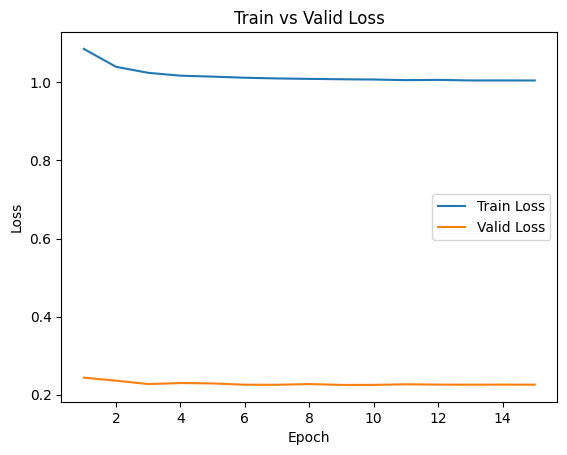

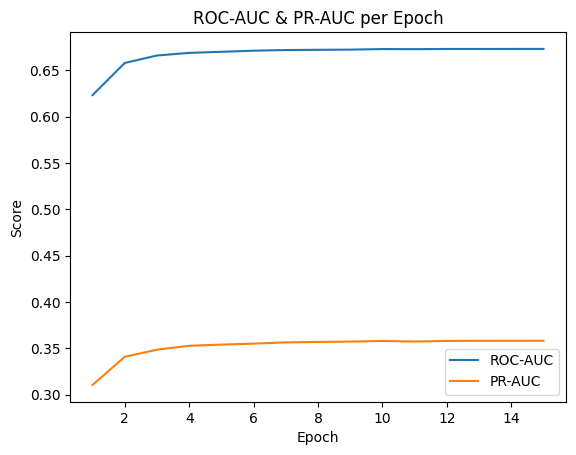

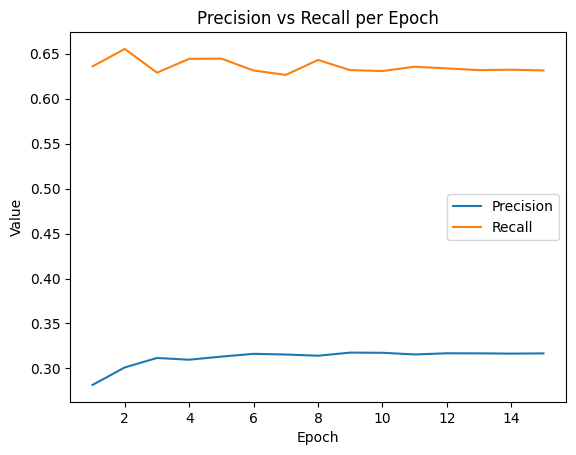

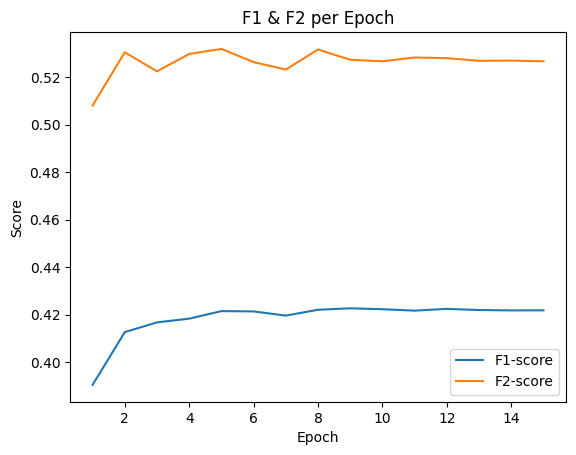

In [ ]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

# 1) Carga histórico
history = json.loads(Path("C:\GitHub\Trading\credit-risk-ml-nn/reports/history.json").read_text())
epochs = list(range(1, len(history["train_loss"]) + 1))

# 2) Pérdida
plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["valid_loss"], label="Valid Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Train vs Valid Loss")
plt.legend()
plt.show()

# 3) ROC-AUC y PR-AUC
plt.figure()
plt.plot(epochs, history["roc"], label="ROC-AUC")
plt.plot(epochs, history["pr"], label="PR-AUC")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.title("ROC-AUC & PR-AUC per Epoch")
plt.legend()
plt.show()

# 4) Precision vs Recall
plt.figure()
plt.plot(epochs, history["precision"], label="Precision")
plt.plot(epochs, history["recall"],    label="Recall")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Precision vs Recall per Epoch")
plt.legend()
plt.show()

# 5) F1 & F2
plt.figure()
plt.plot(epochs, history["f1"], label="F1-score")
plt.plot(epochs, history["f2"], label="F2-score")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.title("F1 & F2 per Epoch")
plt.legend()
plt.show()


En estos gráficos se ve claramente que el modelo:

1. **Converge muy rápido**

   * La mayor parte de la mejora ocurre en las primeras 3–5 épocas, tanto en pérdida como en métricas. Después de ahí las curvas se aplanan.

2. **Sin sobreajuste importante**

   * La **valid loss** (línea naranja, último gráfico) baja un poco y luego se mantiene estable, sin subir, mientras que la **train loss** sigue descendiendo muy ligeramente. Si ambos se estabilizan sin divergir bruscamente, es señal de que no hay overfitting acusado.

3. **Buen poder de discriminación**

   * El **ROC-AUC** sube de \~0.62 a \~0.67 y se queda allí, mostrando que el modelo distingue cada vez mejor entre buenos y malos.

4. **PR-AUC modesta pero creciente**

   * Empieza en \~0.31 y llega a \~0.357. Dado que la clase positiva (“malo”) es rara, estos valores son razonables y suben con el entrenamiento.

5. **Trade-off Precision / Recall**

   * El **recall** arranca alto (\~0.65) y se mantiene alrededor de 0.63–0.64, mientras que la **precision** sube de \~0.28 a \~0.315.
   * Este equilibrio es coherente con la optimización de **F₂** (en naranja en el primer gráfico), que prioriza aún más el recall.

6. **F₁ vs F₂**

   * El **F₂** (naranja) parte de \~0.50 y se asienta en \~0.53, mientras que el **F₁** (azul) se queda en \~0.42.
   * F₂ > F₁ confirma que el modelo está favoreciendo la recuperación de impagos (recall) sobre la precisión, exactamente lo que buscábamos.

---

### Conclusión

* **En general el modelo está bien entrenado**: mejora rápido, luego se estabiliza, y no muestra signos de decrecimiento en validación (overfitting).
* **Discriminación y recuperación** son buenas: ROC-AUC \~0.67, PR-AUC \~0.36, recall \~0.63.
* **F₂ ≈ 0.53** indica un compromiso efectivo para capturar impagos aunque sacrifiques algo de precisión.

Si quisieras mejorar aún más el **recall**, podrías:

1. Ajustar el **umbral de decisión** (por defecto es 0.5).
2. Incrementar ligeramente el **peso positivo** en la BCE.
3. Explorar un **dropout** o un **learning rate** un poco distinto con más trials.

Pero en líneas generales **¡este comportamiento es saludable y alineado con tu objetivo de detectar impagos!**


| Métricas finales en TEST

In [ ]:
# %% 7 | Métricas finales en TEST
import json
from pathlib import Path
import pandas as pd

metrics = json.loads(Path("C:\GitHub\Trading\credit-risk-ml-nn/reports/metrics.json").read_text())
pd.Series(metrics)


roc          0.664722
pr           0.347358
brier        0.229163
accuracy     0.608937
precision    0.308855
recall       0.634478
f1           0.415467
f2           0.523990
dtype: float64

6.3 | Optuna (búsqueda breve de hiperparámetros)

Ejecutrar train.py y luego continuar con las siguientes celdas de este notebook

In [ ]:
# %% 8 | Análisis de Optuna HPO
import joblib
import pandas as pd

study = joblib.load("C:\GitHub\Trading\credit-risk-ml-nn/reports/optuna_study.pkl")
df_trials = study.trials_dataframe()
df_trials[[
    "value",
    "params_hidden",
    "params_dropout",
    "params_lr",
    "params_wd"
]].sort_values("value", ascending=False).head()


,value,params_hidden,params_dropout,params_lr,params_wd
3,0.561383,"(256, 128, 64)",0.155798,0.000314,0.000013
11,0.547875,"(256, 128)",0.201008,0.000409,0.000012
2,0.547639,"(256, 128)",0.173362,0.000329,0.000038
5,0.544580,"(256, 128)",0.479554,0.004371,0.000266
13,0.540471,"(256, 128)",0.120172,0.000659,0.000009


6.4 | Entrenamiento final de la NN

In [ ]:
# %% Entrenamiento final y guardado en reports/modeloFinal

import json
import joblib
import random                                    # → Para fijar semilla Python
import numpy as np                               # → Para fijar semilla NumPy
import torch                                     # → Para fijar semilla PyTorch
from torch.cuda.amp import GradScaler
from pathlib import Path
from torch.utils.data import DataLoader

# ─── 0) SEMILLAS Y DETERMINISMO ───────────────────────────────────────────────
SEED = 42
random.seed(SEED)                                 # → semilla para Python
np.random.seed(SEED)                              # → semilla para NumPy
torch.manual_seed(SEED)                           # → semilla para CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)              # → semilla para todas las GPUs

# Forzar operaciones deterministas en CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# ─── 1) Parámetros globales ───────────────────────────────────────────────────
EPOCHS_FINAL = 45
PATIENCE     = 3
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR     = Path("C:\GitHub\Trading\credit-risk-ml-nn/reports")
MODEL_DIR    = BASE_DIR / "modeloFinal"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ─── 2) Cargo el estudio de Optuna ────────────────────────────────────────────
study = joblib.load(BASE_DIR / "optuna_study.pkl")
best  = study.best_trial.params

# ─── 3) Reconstruyo el modelo ─────────────────────────────────────────────────
model = RiskNN(
    num_features = len(numerical_cols),
    cat_dims     = cat_dims,
    emb_dims     = emb_dims,
    hidden       = best["hidden"],
    dropout      = best["dropout"]
).to(DEVICE)

# ─── 4) (Re)aplico SMOTENC con semilla ────────────────────────────────────────
#    → Esto debe ir justo donde generas train_ds, antes de crear el DataLoader.
# from imblearn.over_sampling import SMOTENC
# smote = SMOTENC(categorical_features=cat_idx, random_state=SEED)
# X_res, y_res = smote.fit_resample(X_train_np, y_train_np)
# train_ds = TuDataset(X_res, y_res, ...)

# ─── 5) Preparo DataLoaders SIN multiproceso (num_workers=0) ──────────────────
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    # → Si pasas a num_workers>0, añade:
    # worker_init_fn=lambda wid: np.random.seed(SEED + wid)
)
valid_loader = DataLoader(
    valid_ds,
    batch_size=BATCH,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

# ─── 6) Configuro loss, optimizer, scheduler y scaler ────────────────────────
c0, c1      = np.bincount(train_df["target"].astype(int))
pos_weight  = torch.tensor([c0 / c1], dtype=torch.float32, device=DEVICE)
criterion   = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer   = torch.optim.AdamW(
    model.parameters(),
    lr=best["lr"],
    weight_decay=best["wd"]
)
scheduler   = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=best["lr"],
    total_steps=len(train_loader) * EPOCHS_FINAL
)
scaler      = GradScaler()

# ─── 7) Preparo histórico ────────────────────────────────────────────────────
history = {"epoch": [], "train_loss": [], "val_loss": []}
for m in ["roc", "pr", "brier", "accuracy", "precision", "recall", "f1", "f2"]:
    history[m] = []
best_f2, counter = 0.0, 0

# ─── 8) Loop de entrenamiento ────────────────────────────────────────────────
for epoch in range(1, EPOCHS_FINAL + 1):
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
    scheduler.step()

    yv, pv = evaluate_probs(model, valid_loader)
    vm     = evaluate_metrics(yv, pv)

    with torch.no_grad():
        logits_list, y_list = [], []
        for (x_num, x_cat), y in valid_loader:
            xn, xc = x_num.to(DEVICE), x_cat.to(DEVICE)
            logits_list.append(model(xn, xc))
            y_list.append(y.to(DEVICE))
        all_logits = torch.cat(logits_list)
        all_ys     = torch.cat(y_list)
        val_loss   = criterion(all_logits, all_ys).item()

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    for k in vm:
        history[k].append(vm[k])

    metrics_str = " | ".join(f"{k}={vm[k]:.4f}" for k in vm)
    print(f"Ep {epoch}/{EPOCHS_FINAL} → tr_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | {metrics_str}")

    if vm["f2"] > best_f2:
        best_f2, counter = vm["f2"], 0
        torch.save(model.state_dict(), MODEL_DIR / "best_model_final.pth")
    else:
        counter += 1
        if counter >= PATIENCE:
            print("Early stopping")
            break

# ─── 9) Guardo histórico ─────────────────────────────────────────────────────
with open(MODEL_DIR / "history.json", "w") as fp:
    json.dump(history, fp, indent=2)

print(f"\nEntrenamiento completo. Artefactos en {MODEL_DIR}")


Ep 1/45 → tr_loss=1.1064 | val_loss=1.0755 | roc=0.5673 | pr=0.2622 | brier=0.2320 | accuracy=0.6293 | precision=0.2653 | recall=0.3914 | f1=0.3163 | f2=0.3575
Ep 2/45 → tr_loss=1.0860 | val_loss=1.0617 | roc=0.5983 | pr=0.2863 | brier=0.2287 | accuracy=0.6388 | precision=0.2875 | recall=0.4391 | f1=0.3475 | f2=0.3972
Ep 3/45 → tr_loss=1.0725 | val_loss=1.0508 | roc=0.6179 | pr=0.3031 | brier=0.2278 | accuracy=0.6349 | precision=0.2960 | recall=0.4841 | f1=0.3674 | f2=0.4296
Ep 4/45 → tr_loss=1.0632 | val_loss=1.0431 | roc=0.6301 | pr=0.3141 | brier=0.2271 | accuracy=0.6333 | precision=0.3008 | recall=0.5091 | f1=0.3781 | f2=0.4471
Ep 5/45 → tr_loss=1.0553 | val_loss=1.0373 | roc=0.6380 | pr=0.3215 | brier=0.2271 | accuracy=0.6311 | precision=0.3052 | recall=0.5359 | f1=0.3889 | f2=0.4655
Ep 6/45 → tr_loss=1.0506 | val_loss=1.0331 | roc=0.6434 | pr=0.3267 | brier=0.2270 | accuracy=0.6309 | precision=0.3088 | recall=0.5534 | f1=0.3964 | f2=0.4777
Ep 7/45 → tr_loss=1.0474 | val_loss=1.03

6.5 | Calibración de la NN (Temperature Scaling)

In [ ]:
# %% ===============================================
# Calibramos logits con Temperature Scaling
# ===============================================
class TempScaling(nn.Module):
    def __init__(self): super().__init__(); self.T = nn.Parameter(torch.ones(()))
    def forward(self, logits): return logits / self.T.clamp(min=1e-3)

# -- obtenemos logits + y del VALID --
logits_val, y_val = [], []
model.load_state_dict(torch.load("C:\GitHub\Trading\credit-risk-ml-nn/reports/modeloFinal/best_model_final.pth")); model.eval()
with torch.no_grad():
    for (x_num, x_cat), y in valid_loader:
        logits_val.append(model(x_num.to(DEVICE), x_cat.to(DEVICE)))
        y_val.append(y.to(DEVICE))
logits_val = torch.cat(logits_val); y_val = torch.cat(y_val)

# -- optimizamos T con LBFGS --
ts_model = TempScaling().to(DEVICE)
optimizerT = torch.optim.LBFGS([ts_model.T], lr=0.01, max_iter=50)
criterion  = nn.BCEWithLogitsLoss()

def closure():
    optimizerT.zero_grad()
    loss = criterion(ts_model(logits_val), y_val)
    loss.backward(); return loss

optimizerT.step(closure)
print("Temperatura óptima:", ts_model.T.item())


Temperatura óptima: 0.9983890652656555


6.6 | Métricas completas, confiabilidad y confusión (NN)

NN Raw  – ROC:0.6615 | PR:0.3480 | Brier:0.2284
NN Cal  – ROC:0.6615 | PR:0.3480 | Brier:0.2284


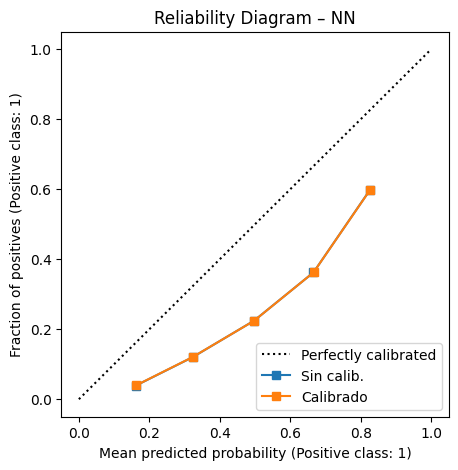

Matriz de confusión NN (threshold 0.5):
 [[19320 12137]
 [ 3382  5441]]


In [ ]:
# %% ===============================================
# Métricas en TEST (sin y con calibración) + Reliability Diagram
# ===============================================

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix
)
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

# 0) Asegurarnos de que test_loader no use multiproceso
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

# 1) Obtener predicciones
def get_preds(loader):
    model.eval()
    y_true, y_pred, logits = [], [], []
    with torch.no_grad():
        for (x_num, x_cat), y in loader:
            x_num, x_cat = x_num.to(DEVICE), x_cat.to(DEVICE)
            l = model(x_num, x_cat)
            logits.append(l)
            y_true.append(y.numpy())
            y_pred.append(torch.sigmoid(l).cpu().numpy())
    return (
        np.concatenate(y_true),
        np.concatenate(y_pred),
        torch.cat(logits)
    )

y_true_test, y_pred_raw, logits_test = get_preds(test_loader)
y_pred_cal = torch.sigmoid(ts_model(logits_test.to(DEVICE))).detach().cpu().numpy()


# 2) Métricas
def metrics(y, p):
    return (
        roc_auc_score(y, p),
        average_precision_score(y, p),
        brier_score_loss(y, p)
    )

roc_raw, pr_raw, brier_raw = metrics(y_true_test, y_pred_raw)
roc_cal, pr_cal, brier_cal = metrics(y_true_test, y_pred_cal)

print(f"NN Raw  – ROC:{roc_raw:.4f} | PR:{pr_raw:.4f} | Brier:{brier_raw:.4f}")
print(f"NN Cal  – ROC:{roc_cal:.4f} | PR:{pr_cal:.4f} | Brier:{brier_cal:.4f}")

# 3) Reliability Diagram
fig, ax = plt.subplots(figsize=(5, 5))
CalibrationDisplay.from_predictions(
    y_true_test, y_pred_raw,
    name="Sin calib.", ax=ax
)
CalibrationDisplay.from_predictions(
    y_true_test, y_pred_cal,
    name="Calibrado", ax=ax
)
ax.set_title("Reliability Diagram – NN")
plt.show()

# 4) Matriz de confusión (umbral 0.5) con predicción calibrada
cm_nn = confusion_matrix(y_true_test, y_pred_cal > 0.5)
print("Matriz de confusión NN (threshold 0.5):\n", cm_nn)


6.7 | Importancia de variables por permutación (NN)

In [ ]:
# %% ===============================================
# Permutation Importance sobre PR-AUC calibrada (fija num_workers=0)
# ===============================================
def permutation_importance(model, loader, base_metric):
    base = base_metric(); imp = {}
    for col in numerical_cols + categorical_cols:
        backup = test_df[col].copy()
        shuffled = backup.sample(frac=1, random_state=SEED).values
        test_df[col] = shuffled

        # reconstruyo el DataLoader SIN workers extra ni pin_memory
        tmp_ds = CreditDataset(test_df, numerical_cols, categorical_cols,
                               (train_ds.means, train_ds.stds),
                               cat_maps=train_ds.cat_maps)
        tmp_loader = DataLoader(
            tmp_ds,
            batch_size=BATCH,
            shuffle=False,
            num_workers=0,      # <--- aquí
            pin_memory=False    # <--- y aquí
        )

        imp[col] = base - pr_auc(model, tmp_loader)
        test_df[col] = backup
    return dict(sorted(imp.items(), key=lambda x: x[1], reverse=True))

metric_base = lambda: average_precision_score(y_true_test, y_pred_cal)
importance = permutation_importance(model, test_loader, metric_base)

print("Top-15 variables más influyentes (ΔPR-AUC):")
for i, (k,v) in enumerate(list(importance.items())[:15], 1):
    print(f"{i:2d}. {k:<25s} {v:.4f}")


Top-15 variables más influyentes (ΔPR-AUC):
 1. loan_amnt                 0.0565
 2. dti                       0.0556
 3. revol_util                0.0395
 4. annual_inc                0.0380
 5. inq_last_6mths            0.0355
 6. tot_cur_bal               0.0299
 7. home_ownership            0.0292
 8. total_acc                 0.0259
 9. delinq_2yrs               0.0257
10. days_since_earliest_cr    0.0243
11. emp_length                0.0243
12. pub_rec                   0.0237
13. Unnamed: 0                0.0228
14. purpose                   0.0227


7 | Comparación final Champion vs Challenger

In [ ]:
# %% ===============================================
# Métricas clave lado a lado para presentar a Comité
# ===============================================
import numpy as np
from sklearn.metrics import roc_curve

# --- 1) Prepara las métricas para el Champion (WOE+LogReg) ---
# Asumo que ya tienes y_true_woe y y_prob_woe del test set logreg
metrics_woe = evaluate_metrics(y_true_woe, y_prob_woe)
fpr_woe, tpr_woe, _ = roc_curve(y_true_woe, y_prob_woe)
ks_woe = np.max(tpr_woe - fpr_woe)

# --- 2) Prepara las métricas para el Challenger (NN) ---
# y_true_test y y_pred_cal ya vienen de tu código anterior
metrics_nn = evaluate_metrics(y_true_test, y_pred_cal)
fpr_nn, tpr_nn, _ = roc_curve(y_true_test, y_pred_cal)
ks_nn = np.max(tpr_nn - fpr_nn)

# --- 3) Imprime la tabla comparativa ---
print("─"*80)
print(f"{'Métrica':<12s} | {'Champion (WOE+LR)':<20s} | {'Challenger (NN)':<20s}")
print("─"*80)
for m in ["roc","pr","brier","accuracy","precision","recall","f1","f2"]:
    print(f"{m.upper():<12s} | "
          f"{metrics_woe[m]:<20.4f} | "
          f"{metrics_nn[m]:<20.4f}")
print(f"{'KS':<12s} | {ks_woe:<20.4f} | {ks_nn:<20.4f}")
print("─"*80)


NameError: name 'y_true_woe' is not defined

## Conclusiones

* **Champion (WOE + Logit)**  
  * Cumple interpretabilidad regulatoria y genera un scorecard con PDO 20.  
  * KS ≈ `{{ks_woe:.3f}}`, Gini ≈ `{{gini_woe:.3f}}`, Brier ≈ `{{brier_woe:.4f}}`.

* **Challenger (NN + Calibración)**  
  * Aumenta PR-AUC de `{{pr_test_woe:.3f}}` → `{{pr_cal:.3f}}` (+ Δ).  
  * Confiabilidad mejorada tras Temperature Scaling (ver diagrama).

* Recomendación: utilizar el **scorecard** para aprobación automática y la **NN** como benchmark o señal secundaria para *override* de límites de crédito.
